# Faster RCNN

## Identical Initial Setting as FAST RCNN

In [1]:
import os 
import glob
import pandas as pd
from collections import Counter 
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split


import torch

import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from torchsummary import summary


from torchvision import models
from torchvision import transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

from dataload import xml_to_csv,PetData,Sub_region_train,Sub_region

from tqdm import tqdm

from metrics import iou

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [2]:
##Loading data
#root_path="D:/Dataset/Pet_Data/"
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")
seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))  
## 
train, valid = train_test_split(balanced_df, test_size=0.3,random_state=seed)  

BATCH_SIZE = 1




In [3]:
from dataload import PetData_FASTRCNN

In [4]:
train_ds = PetData_FASTRCNN(train, train=True, ssearch=True)
valid_ds= PetData_FASTRCNN(valid, train=False,ssearch=True)

BATCH_SIZE=2
def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

## Region Proposal Network

![RPN](https://i.imgur.com/QKZtjVM.png)

In [33]:
IMGSIZE=(224,224)
ANCHOR_POINTS=[]

In [785]:
_RATIO=224//16

In [786]:
CENTER_X=np.arange(16,(_RATIO+1)*16,16)
CENTER_Y=np.arange(16,(_RATIO+1)*16,16)
CENTER_POINTS=torch.tensor([(y,x) for x in CENTER_Y for y in CENTER_X],dtype=torch.float32)  
print(CENTER_POINTS.shape)
SAMPLE_DATA=train_ds[3]
IMG,GT_BOX,_,_,_=SAMPLE_DATA

torch.Size([196, 2])


## ANCHOR COORDINATES DISPLAY

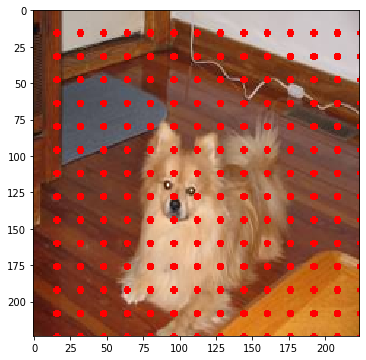

In [787]:
pil_img=T.ToPILImage()((IMG*0.5)+0.5)
img=np.asarray(pil_img)
plt.figure(figsize=(6, 6))
for ctr in CENTER_POINTS:
    cv2.circle(img, (int(ctr[0]), int(ctr[1])), radius=1, color=(255, 0, 0), thickness=2) 
plt.imshow(img)
plt.show()    

In [878]:
# We follow default of Faster_RCNN's baseline
ANCHOR_SCALES = [16,32,64] #CONTROLS THE RELATIVE SIZE OF WITHIN ANCHOR BOXES 
ANCHOR_RATIOS = [0.5,1,2] #CONTROLS THE RELATIVE ASPECT RATIO  OF ANCHOR BOXES
SAMPLE_RATIO =2 #CONTROLS THE MINIMUM SIZE OF ANCHOR BOXES


We have $(14 \times 14)$ anchor points each anchor points have  $($NUM_OF_SCALES $\times$ NUM_OF_RATIOS$)$ variations

## Creating anchor boxes

In [879]:
anchors_num=len(ANCHOR_RATIOS)*len(ANCHOR_SCALES)

anchor_boxes = torch.zeros( ((_RATIO * _RATIO * len(ANCHOR_RATIOS)*len(ANCHOR_SCALES)), 4))
point_idx=0
for _,c in enumerate(CENTER_POINTS):
    ctr_y, ctr_x = c
    for i in range(len(ANCHOR_RATIOS)):
        for j in range(len(ANCHOR_SCALES)):
            h = SAMPLE_RATIO * ANCHOR_SCALES[j] * np.sqrt(ANCHOR_RATIOS[i])
            w = SAMPLE_RATIO * ANCHOR_SCALES[j] * np.sqrt(1./ ANCHOR_RATIOS[i])
            anchor_boxes[point_idx, 0] = ctr_x - w / 2.
            anchor_boxes[point_idx, 1] = ctr_y - h / 2.
            anchor_boxes[point_idx, 2] = ctr_x + w / 2.
            anchor_boxes[point_idx, 3] = ctr_y + h / 2

            point_idx+=1
           # print(point_idx)

print(anchor_boxes.shape)

torch.Size([1764, 4])


In [880]:
for idx,i in enumerate(anchor_boxes): 
    xc=int((i[0]+i[2])/2)
    yc=int((i[1]+i[3])/2)
    if xc ==112 and yc ==112:
        center_index=idx
        break

## ANCHOR BOXES DISPLAY

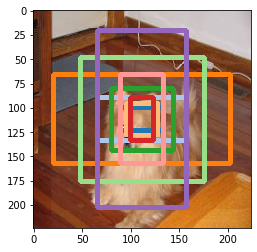

In [881]:
import seaborn as sns
palette = sns.color_palette("tab20")
pil_img=T.ToPILImage()((IMG*0.5)+0.5)
img=np.asarray(pil_img)

for idx,i in enumerate(range(center_index, center_index+anchors_num)): 
    x0 = int(anchor_boxes[i][0])
    y0 = int(anchor_boxes[i][1])
    x1 = int(anchor_boxes[i][2])
    y1 = int(anchor_boxes[i][3])
    cv2.rectangle(img, (x0, y0), (x1, y1), np.asarray(palette[idx])*255, thickness=3) 

    
plt.imshow(img)
plt.show()  

## REMOVING ANCHOR OUT OF BOXES

Before Removal: torch.Size([1764, 4])
After Removal:torch.Size([877, 4])


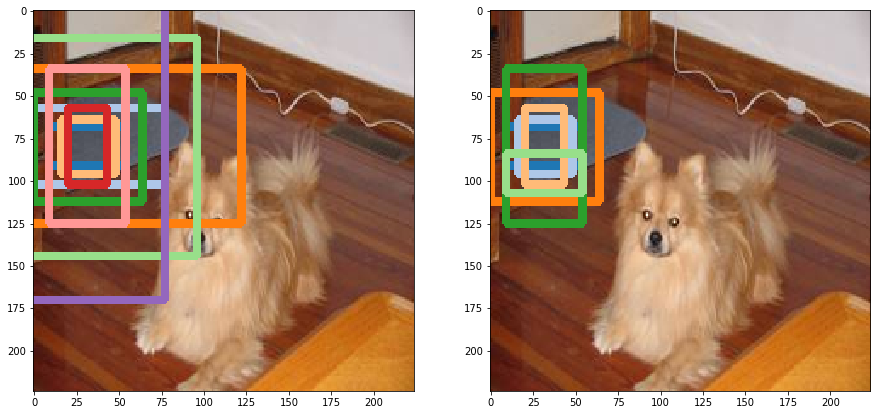

In [882]:
import seaborn as sns

img=np.asarray(T.ToPILImage()((IMG*0.5)+0.5))
##plt.figure(figsize=(20,20))
fig,ax=plt.subplots(1,2,figsize=(15,15))
for idx,i in enumerate(range(162, 162+anchors_num)): 
    x0 = int(anchor_boxes[i][0])
    y0 = int(anchor_boxes[i][1])
    x1 = int(anchor_boxes[i][2])
    y1 = int(anchor_boxes[i][3])
    cv2.rectangle(img, ( x0,y0), ( x1,y1), np.asarray(palette[idx])*255, thickness=3) 
ax[0].imshow(img)

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= IMGSIZE[0]) &
        (anchor_boxes[:, 3] <= IMGSIZE[1])
    )[0]
valid_anchor_boxes = anchor_boxes[index_inside]

print(f'Before Removal: {anchor_boxes.shape}')
print(f'After Removal:{valid_anchor_boxes.shape}')

img=np.asarray(T.ToPILImage()((IMG*0.5)+0.5))

for idx,i in enumerate(index_inside[(np.where((index_inside >=162) & (index_inside <=162+anchors_num))[0])]): 
    x0 = int(anchor_boxes[i][0])
    y0 = int(anchor_boxes[i][1])
    x1 = int(anchor_boxes[i][2])
    y1 = int(anchor_boxes[i][3])
    cv2.rectangle(img, ( x0,y0), ( x1,y1), np.asarray(palette[idx])*255, thickness=3) 
ax[1].imshow(img)
plt.show()  




## IOU cal of ANCHOR BOXES

In [872]:
ious=torch.zeros((len(valid_anchor_boxes),len(GT_BOX)))  #Each iou contains iou with each gt bounding box of the image, this case only one gt bbox per image
for box_idx,box in enumerate(valid_anchor_boxes):
    for gt_box_idx,gt_box in enumerate(GT_BOX):
        iou_area=iou.torch_getIOU(box,gt_box[0:4])
        ious[box_idx,gt_box_idx]=iou_area

In [873]:
len(ious)

2324

##  Top  box with Each GT_BOX

In [874]:
val,indices=torch.max(ious,axis=0)

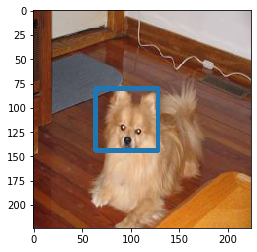

In [875]:
top_5_box=torch.topk(ious,axis=0,k=5)
plt.figure()
img=np.asarray(T.ToPILImage()((IMG*0.5)+0.5))

for idx,i in enumerate(valid_anchor_boxes[indices].squeeze(1)): 
    x0 = int(i[0])
    y0 = int(i[1])
    x1 = int(i[2])
    y1 = int(i[3])
    cv2.rectangle(img, (x0, y0), (x1, y1), np.asarray(palette[idx])*255, thickness=3) 
plt.imshow(img)
plt.show()  


In [876]:
top_5_box

torch.return_types.topk(
values=tensor([[0.7309],
        [0.6402],
        [0.6389],
        [0.5807],
        [0.5400]]),
indices=tensor([[ 948],
        [ 952],
        [1162],
        [ 932],
        [ 972]]))

In [843]:
top_5_box

torch.return_types.topk(
values=tensor([[0.7309],
        [0.6514],
        [0.6402],
        [0.6389],
        [0.5807]]),
indices=tensor([[753],
        [757],
        [758],
        [918],
        [743]]))

## Make Labels for anchor box 1:object, 0:background -1:None

![img](https://i.imgur.com/C4fpjBg.png)
![img](https://i.imgur.com/1eGALoQ.png)


In [832]:
POS_THRESH_ANC=0.7
NEG_THRESH_ANC=0.3
labels=torch.ones(len(ious))*-1
labels[indices]=1
maxious=torch.max(ious,axis=1).values
labels[torch.where(maxious>=POS_THRESH_ANC)]=1
labels[torch.where(maxious<NEG_THRESH_ANC)]=0

## MINI_BATCH

In [833]:
num_sample=64
pos_samples=int(num_sample*0.5)
neg_samples=num_sample-pos_samples
pos_index=torch.where(labels==1)[0]
neg_index=torch.where(labels==0)[0]
pos_anc=torch.cat([valid_anchor_boxes[torch.stack(random.choices(pos_index,k=pos_samples))],torch.ones(pos_samples,1)],dim=1)
neg_anc=torch.cat([valid_anchor_boxes[torch.stack(random.choices(neg_index,k=neg_samples))],torch.zeros(neg_samples,1)],dim=1)
mini_batch=torch.cat([pos_anc,neg_anc])

In [834]:
pos_index

tensor([753])

In [745]:
valid_anchor_boxes[torch.stack(random.choices(pos_index,k=pos_samples))].shape

torch.Size([32, 4])

In [688]:
#Input is CONV Feature MAP
#model=models.resnet18(pretrained=True).features[0:-1]
model_ft_extractor=models.vgg16(pretrained=True).features[0:-1]
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si